(lecture05:models-are-functions)=
# Models are functions

Let's now make our first model.
A model is always some kind of function.
It takes some input variables an it maps them to an output quantity of interest.
A good model is one in which the input variables are the causes of the output quantity of interest.
Let's make our first model for the `temperature_raw.xlsx` dataset of {ref}`lecture03:homework`.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'svg')

Download, and load the data:

In [8]:
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)
   
# The url of the file we want to download
url = 'https://github.com/PurdueMechanicalEngineering/me-297-intro-to-data-science/raw/master/data/temperature_raw.xlsx'
download(url)
import pandas as pd
df = pd.read_excel('temperature_raw.xlsx')
df = df.dropna(axis=0)
df.head()

,household,date,score,t_out,t_unit,hvac
0,a1,2018-01-07,100.0,4.283373,66.693229,246.473231
1,a10,2018-01-07,100.0,4.283373,66.356134,5.492116
2,a11,2018-01-07,58.0,4.283373,71.549132,402.094327
3,a12,2018-01-07,64.0,4.283373,73.429514,211.692244
4,a13,2018-01-07,100.0,4.283373,63.923937,0.850536


The output we want to look at is `hvac`, the weekly energy consumption of a unit.
What affects the weekly energy consumption?
Well, obviously the external temperature `t_out`.
The smaller the `t_out` the more energy we need to keep a unit at a certain internal temperature.
So, definetely, `t_out` is one of the causes of `hvac`.
Let's do the scatter plot of the two variables to see what kind of relationship we have:

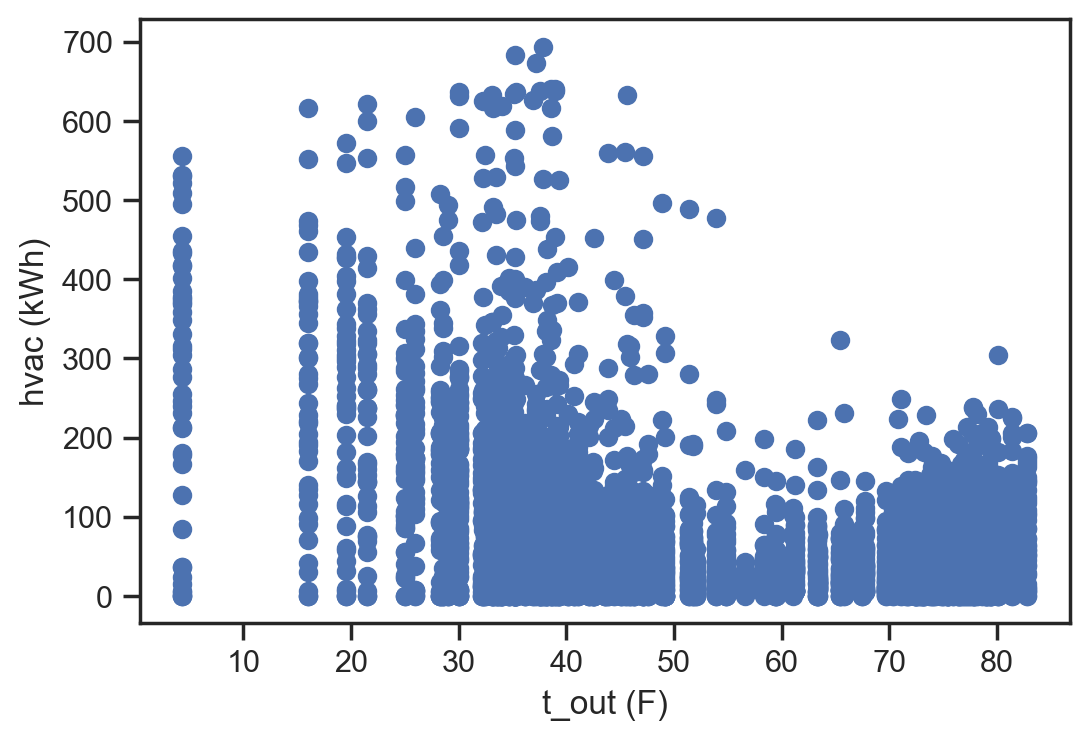

In [9]:
fig, ax = plt.subplots()
ax.scatter(df['t_out'], df['hvac'])
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)');

Okay, it's kind of a mess, but we see four important trends that make sense:
+ The energy consumption goes up when the external temperature gets very cold. This makes sense because for very cold external temperatures the occupants are running their heating.
+ The energy consuption is at a minimum when the external temperature is around 60 degrees F.
This also makes sense. The wether is nice, the occupants shut down their heating.
+ Then, the energy consumption also goes up when the external temperature becomes hotter.
This is because the occupants start using their cooling.
+ Finally, when the external temperature is around 60 degrees F, the average energy consumption does not become exactly zero.

In summary:
+ `hvac` $\downarrow$ if `t_out` $< 60$ deg F.
+ `hvac` $\uparrow$ if `t_out` $> 60$ deg F.
+ When `t_out` is 60, there is some nonzero average `hvac`.

What is the simplest function that captures these trends?
Well, thta would be a parabola centered at 60 degrees F.
This one:
$$
\text{hvac} = \text{hvac}(\text{t_out}) = a (\text{t_out} - 60)^2 + b,
$$
for some parameter $a$ that we need to pick.
This is our first model!
This is a function.
Let's implement the function in Python:

In [20]:
def hvac_model(t_out, a, b, t_out_min=60):
    """
    A naïve model of weekly HVAC energy consumption (kWh) as a function of external temperature t_out.
    The mathematical form of the model is:
    
        hvac = a * (t_out - t_out_min)^2 + b
    
    Arguments:
    t_out      -   The average external temperature in degrees F (average over a week).
    a          -   A parameter to be calibrated using observed data. In units of kWh / (deg F)^2.
    b          -   Another parameter to be calibrated using observed data. This is in units of kWh.
                   It is the energy consumption when the HVAC system is not used.
    t_out_min  -   The external temperature above at which the occupants feel comfortable without using
                   their HVAC system.
    
    Returns: The weekly HVAC energy consumption in kWh.
    """
    return a * (t_out - t_out_min) ** 2 + b

Now we have to calibrate the parameter.

## Calibrating our first model manually

Let's try to manually pick this parameter $a$.
We are going to do this:
+ pick a value for $a$
+ plot the scatter plot of `t_out` and `hvac`
+ plot the model `hvac(t_out)`
+ compare the results

Here we go:

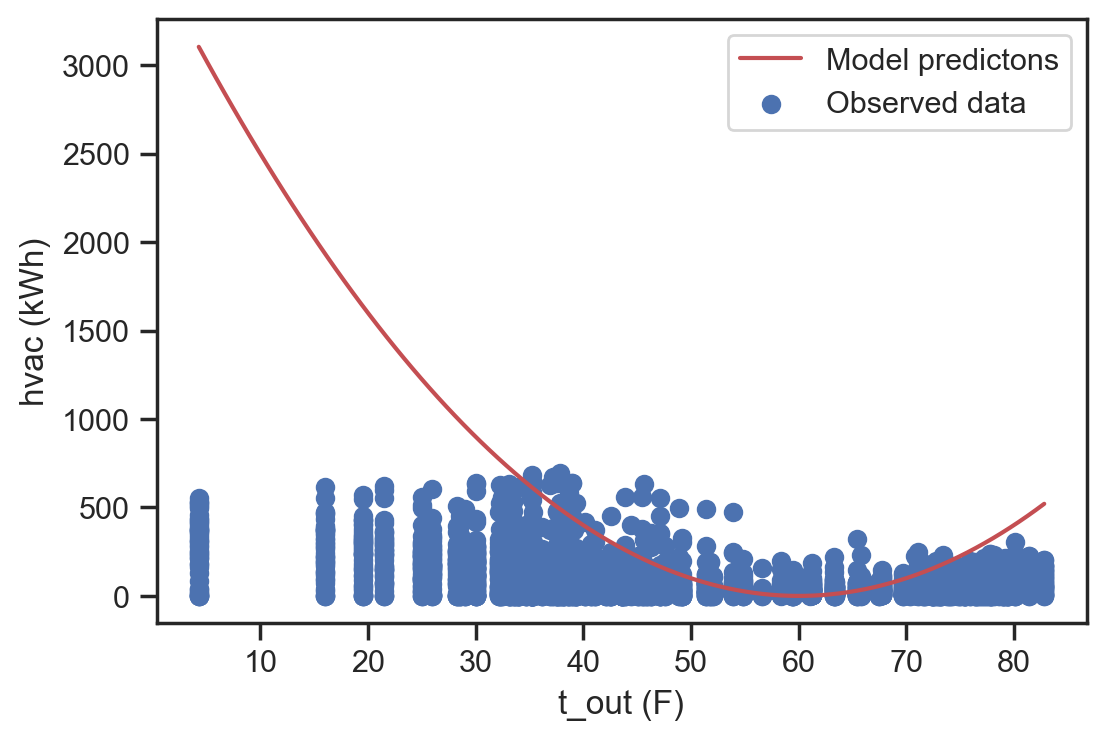

In [27]:
import numpy as np

a = 1 # in kWh / F^2
b = 0 # in kWh
fig, ax = plt.subplots()

# First the scatter plot of all the data we have
ax.scatter(df['t_out'], df['hvac'], label='Observed data')
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')

# Now pick some temperatures to use our model on:
t_outs = np.linspace(df['t_out'].min(), df['t_out'].max(), 100)
predicted_hvac = hvac_model(t_outs, a, b)
ax.plot(t_outs, predicted_hvac, 'r', label='Model predictons')
plt.legend(loc='best');

This is not every good.
Maybe my $a$ parameter is too big.
Let me try something smaller.

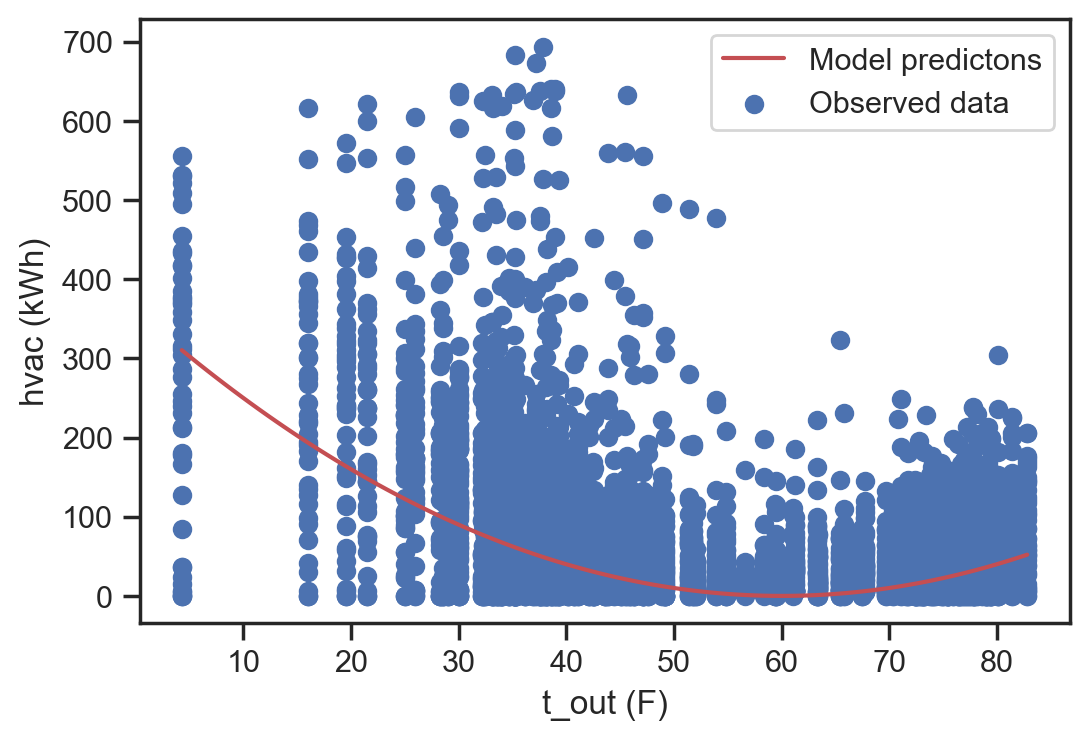

In [29]:
a = 0.1 # in kWh / F^2
b = 0 # in kWh
fig, ax = plt.subplots()

# First the scatter plot of all the data we have
ax.scatter(df['t_out'], df['hvac'], label='Observed data')
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')

# Now pick some temperatures to use our model on:
t_outs = np.linspace(df['t_out'].min(), df['t_out'].max(), 100)
predicted_hvac = hvac_model(t_outs, a, b)
ax.plot(t_outs, predicted_hvac, 'r', label='Model predictons')
plt.legend(loc='best');

This looks better.
But I would like to push the model up a little bit.
I can do this by varying the $b$:

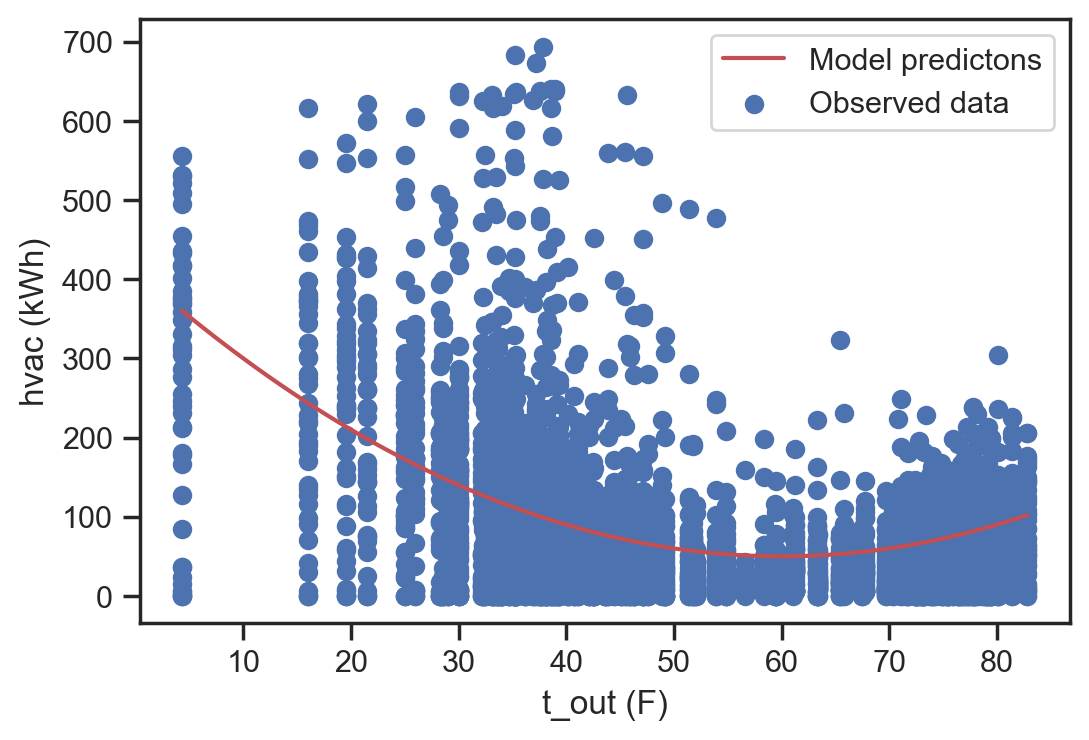

In [30]:
a = 0.1 # in kWh / F^2
b = 50 # in kWh
fig, ax = plt.subplots()

# First the scatter plot of all the data we have
ax.scatter(df['t_out'], df['hvac'], label='Observed data')
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')

# Now pick some temperatures to use our model on:
t_outs = np.linspace(df['t_out'].min(), df['t_out'].max(), 100)
predicted_hvac = hvac_model(t_outs, a, b)
ax.plot(t_outs, predicted_hvac, 'r', label='Model predictons')
plt.legend(loc='best');

For manual parameter calibration, this looks pretty good!

```{note}
In the technical jargon, we have made a regression model.
In particular, we have made a linear regression model.
The correct way to calibrate the parameters of a linear regression model is via the so-called least squares method.
We will learn the mathematics of least squares in a {ref}`lecture13`.
```

## Making predictions with our model

Let's make some predictions with our model.
Let's look at high temperatures which are missing form our dataset.
Say from 80 deg. F to 110 deg. F, what weekly average HVAC energy consumption should we expect?

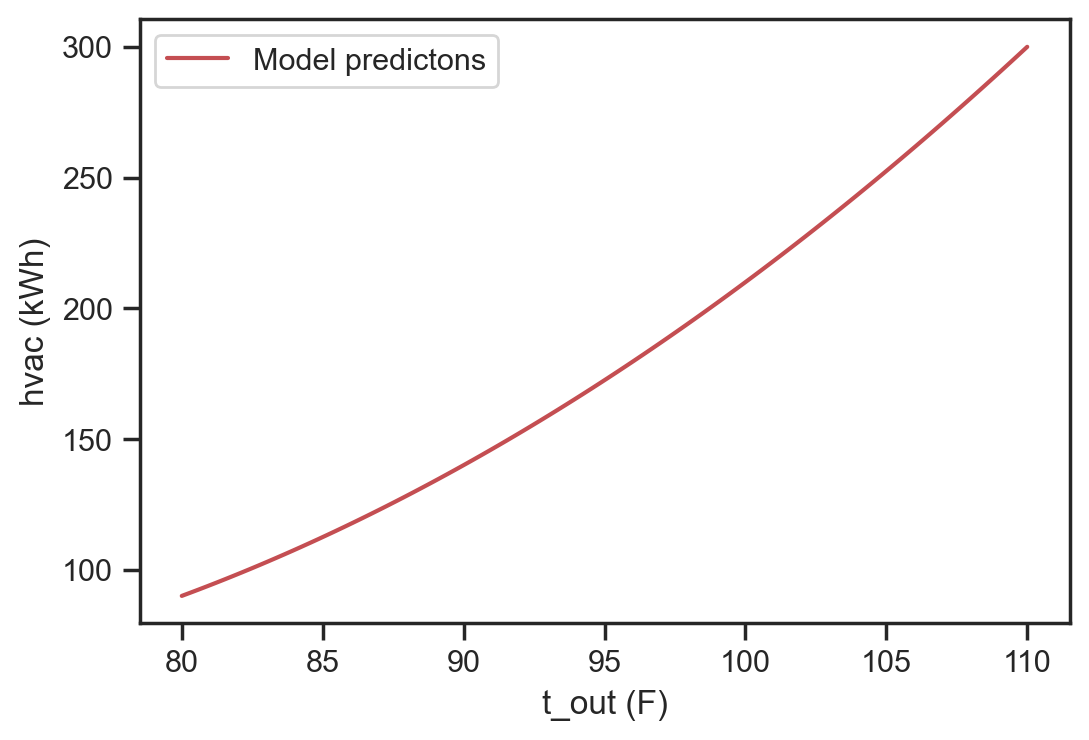

In [31]:
fig, ax = plt.subplots()
t_outs = np.linspace(80, 110, 100)
predicted_hvac = hvac_model(t_outs, a, b)
ax.plot(t_outs, predicted_hvac, 'r', label='Model predictons')
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')
plt.legend(loc='best');

Note that even though the prediction is unlikely to be correct, it can still be very useful.
For example, you can use it to plan how much electricity load you are likely to need in an extreme head event.

## Questions

For simple models like the one above, you can use Python's interactive plotting capabilities to make an even better manual choice of the parameters.
I am not going to explain how the code below works, but if you feel like digging deeper on your own time, then be my guest!

<IPython.core.display.Javascript object>


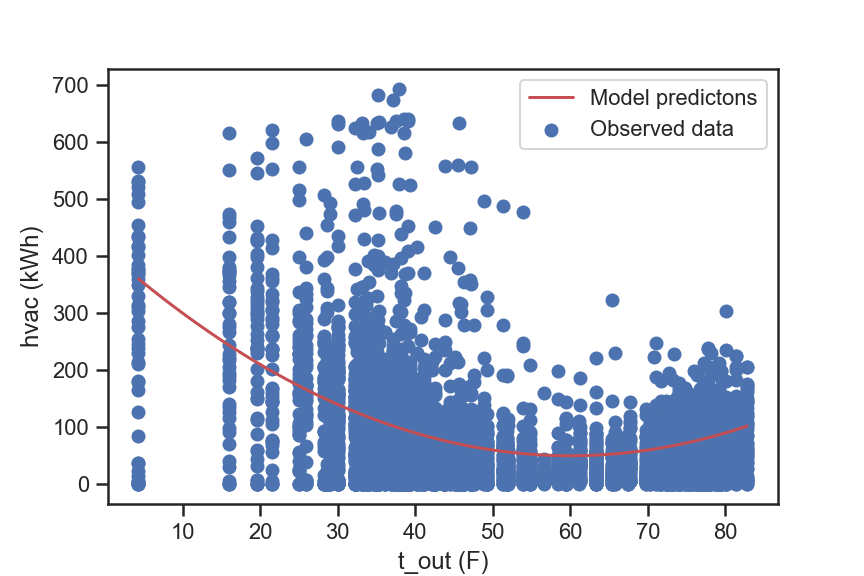

interactive(children=(FloatSlider(value=0.1, description='a', max=0.30000000000000004, min=-0.1), IntSlider(va…

In [35]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


a = 0.1 # in kWh / F^2
b = 50 # in kWh
fig, ax = plt.subplots()

# First the scatter plot of all the data we have
ax.scatter(df['t_out'], df['hvac'], label='Observed data')
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')

# Now pick some temperatures to use our model on:
t_outs = np.linspace(df['t_out'].min(), df['t_out'].max(), 100)
predicted_hvac = hvac_model(t_outs, a, b)
line, = ax.plot(t_outs, predicted_hvac, 'r', label='Model predictons')
plt.legend(loc='best');

def update(a=0.1, b=50, t_out_min=60):
    line.set_ydata(hvac_model(t_outs, a, b, t_out_min=t_out_min))
    fig.canvas.draw_idle()

interact(update);

+ Play with the interactive plot above and see if you can find a better set of parameters. You need to run this Jupyter notebook on Google Colab of course.